In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset 
import torch.nn.functional as F
import tqdm

In [74]:
# SCALER = 'NONE'
SCALER = 'MINMAX'
# LAST_N = -15
TRAIN_TEST_SPLIT = 0.95
BATCH_SIZE = 64

In [75]:
df = pd.read_csv('total.csv')
df.head()

,Date,S&P,currency,gold,kospi,kospi_shift
0,2003-12-01,1070.119995,1198.400024,402.700012,807.390015,807.780029
1,2003-12-02,1066.619995,1195.000000,403.700012,807.780029,808.340027
2,2003-12-03,1064.729980,1192.500000,403.899994,808.340027,805.130005
3,2003-12-04,1069.719971,1190.099976,403.299988,805.130005,789.409973
4,2003-12-05,1061.500000,1184.699951,406.399994,789.409973,784.799988


In [76]:
df.tail()

,Date,S&P,currency,gold,kospi,kospi_shift
5339,2024-05-17,5303.270020,1346.040039,2412.199951,2724.620117,2742.139893
5340,2024-05-20,5308.129883,1353.390015,2433.899902,2742.139893,2724.179932
5341,2024-05-21,5321.410156,1360.160034,2421.699951,2724.179932,2723.459961
5342,2024-05-22,5307.009766,1363.420044,2389.199951,2723.459961,2721.810059
5343,2024-05-23,5307.009766,1363.420044,2365.199951,2721.810059,2721.810059


In [77]:
# train test split
df_train = df.iloc[:int(len(df) * TRAIN_TEST_SPLIT), :]
df_test = df.iloc[int(len(df) * TRAIN_TEST_SPLIT): , :]
# df_train = df.iloc[:int(len(df) * TRAIN_TEST_SPLIT), :].drop('Date', axis=1)
# df_test = df.iloc[int(len(df) * TRAIN_TEST_SPLIT): , :].drop('Date', axis=1)
# train_x, test_x, train_y, test_y = train_test_split(df_1.loc[:, 'S&P':'kospi'], df_1.loc[:, 'kospi_shift'], train_size=0.9)
col_names = df_train.columns.values
print(col_names)

['Date' 'S&P' 'currency' 'gold' 'kospi' 'kospi_shift']


In [78]:
scale_params = pd.DataFrame(index=['mean', 'var', 'max', 'min'])
for i in col_names[1:]:
    scale_params[i] = [df_train[i].mean(), df_train[i].var(), df_train[i].max(), df_train[i].min()]
scale_params

,S&P,currency,gold,kospi,kospi_shift
mean,2.060187e+03,1120.468225,1212.153132,1908.118825,1908.346142
var,1.040263e+06,11179.495861,197490.747079,285130.964445,285101.043571
max,4.796560e+03,1571.400024,2051.500000,3305.209961,3305.209961
min,6.765300e+02,886.679993,374.799988,719.590027,719.590027


In [79]:
# scaling
train_data = pd.DataFrame()
test_data = pd.DataFrame()
if SCALER == 'MINMAX':
    for i in col_names[1:]:
        train_data[i] = df_train[i].apply(lambda x: (x - scale_params.loc['min', i])/(scale_params.loc['max', i] - scale_params.loc['min', i]))
        test_data[i] = df_test[i].apply(lambda x: (x - scale_params.loc['min', i])/(scale_params.loc['max', i] - scale_params.loc['min', i]))
elif SCALER == 'NORMAL':
    for i in col_names[1:]:
        train_data[i] = df_train[i].apply(lambda x: (x - scale_params.loc['mean', i])/scale_params.loc['var', i])
        test_data[i] = df_test[i].apply(lambda x: (x - scale_params.loc['mean', i])/scale_params.loc['var', i])
elif SCALER == 'NONE':
    for i in col_names[1:]:
        train_data[i] = df_train[i]
        test_data[i] = df_test[i]

test_data.tail()

,S&P,currency,gold,kospi,kospi_shift
5339,1.122987,0.670873,1.215125,0.775454,0.782230
5340,1.124167,0.681607,1.228067,0.782230,0.775284
5341,1.127390,0.691494,1.220791,0.775284,0.775006
5342,1.123895,0.696255,1.201407,0.775006,0.774367
5343,1.123895,0.696255,1.187094,0.774367,0.774367


In [80]:
len(df_test)

268

In [81]:
class StockDataset(Dataset):
    def __init__(self, data, input_window=128, output_window=1, stride=1):
        #총 데이터의 개수
        # print(data.shape)
        L = data.shape[0]
        features = data.shape[1] - 1
        #stride씩 움직일 때 생기는 총 sample의 개수
        num_samples = (L - input_window - output_window) // stride + 1
        start_pos = (L - input_window - output_window) % stride
        iter_times = (L - input_window - output_window) // stride + 1
        # print(data.shape, num_samples, iter_times, start_pos, L)

        #input과 output
        X = np.zeros([num_samples, input_window, features])
        Y = np.zeros([num_samples, output_window])
        # print(X.shape, Y.shape)
        for i in np.arange(num_samples):
            start_x = start_pos + i * stride
            end_x = start_x + input_window
            X[i, :, :] = data.iloc[start_x:end_x, :-1]

            # end_y = start_y + output_window
            # print(i, start_x, end_x)
            Y[i, :] = data.iloc[end_x: end_x + output_window, -1:]
        # print(X.shape, Y.shape)
        # X = X.reshape(X.shape[0], X.shape[1], 1).transpose((1,0,2))
        # Y = Y.reshape(Y.shape[0], Y.shape[1], 1).transpose((1,0,2))
        print(X.shape, Y.shape)
        self.x = X
        self.y = Y
        
        self.len = len(X)
    def __getitem__(self, i):
        return self.x[i], self.y[i]
    def __len__(self):
        return self.len

In [82]:
train_dataset = StockDataset(train_data, 128, 1, 1)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = StockDataset(test_data, 128, 1, 1)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
a1 = next(iter(train_dataset))
print(len(train_dataloader), len(train_dataloader.dataset), a1[0].shape, a1[1].shape)
# print(a1)

(4948, 128, 4) (4948, 1)
(140, 128, 4) (140, 1)
78 4948 (128, 4) (1,)


In [83]:
print(next(iter(test_dataset))[0].shape, next(iter(test_dataset))[1].shape)

(128, 4) (1,)


In [84]:
128*128

16384

### Make a MLP model

In [85]:
class StockMLP(nn.Module):
    def __init__(self, in_ch, input_window, seq_len, output_window):
        super().__init__()
        self.conv1d_1 = nn.Conv1d(in_channels=in_ch, out_channels=input_window//2, kernel_size=3, padding=1)
        self.conv1d_2 = nn.Conv1d(in_channels=input_window//2, out_channels=input_window//2, kernel_size=3, padding=1)
        self.conv1d_3 = nn.Conv1d(in_channels=input_window//2, out_channels=input_window, kernel_size=3, padding=1)
        self.flatten = nn.Flatten()
        self.in_size = input_window * seq_len
        self.fc1 = nn.Linear(self.in_size, self.in_size//10)
        self.fc2 = nn.Linear(self.in_size//10, self.in_size//10)
        self.fc3 = nn.Linear(self.in_size//10, self.in_size//100)
        self.fc4 = nn.Linear(self.in_size//100, self.in_size//100)
        self.fc5 = nn.Linear(self.in_size//100, self.in_size//1000)
        self.fc6 = nn.Linear(self.in_size//1000, output_window)
        self.dropout = nn.Dropout(0.2)
    
    def forward(self, x):
        # print('start:', x.size())
        x = x.transpose(1, 2).contiguous()
        # print('transpose:', x.size())
        x = self.conv1d_1(x)
        x = self.conv1d_2(x)
        x = self.conv1d_3(x)
        x = x.transpose(1, 2).contiguous()
        # print('end:', x.size())
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = F.relu(self.fc4(x))
        x = self.dropout(x)
        x = F.relu(self.fc5(x))
        x = self.dropout(x)
        x = F.relu(self.fc6(x))
        return x

In [86]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_d = 256
seq_len = 128
lr = 1e-4
in_ch = 4
lr_sched = True
model = StockMLP(in_ch, model_d, seq_len, 1).to(device)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
if lr_sched == True:
    # scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer=optimizer,
    #                                     lr_lambda=lambda epoch: 0.95 ** epoch,
    #                                     last_epoch=-1,
    #                                     verbose=False)
    # scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)

### Train

In [87]:
loss_result = pd.DataFrame(columns=['epochs', 'loss'])
epochs = 1000
for epoch in range(epochs):
    running_loss = 0.0
    for _, data in enumerate(train_dataloader):
        # print(data[0].shape)
        # print(data[1].shape)
        inputs = data[0].to(device).float()
        outputs = data[1].to(device).float()
        # model.training()
        # print(inputs)

        optimizer.zero_grad()
        result = model(inputs)
        # print(result.size(), outputs.size())
        loss = loss_fn(result, outputs.reshape(-1, 1))
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    print(f'epoch #{epoch} loss: {running_loss:.6f}')
    loss_result.loc[epoch] = [epoch, running_loss]

epoch #0 loss: 1.952569
epoch #1 loss: 0.700783
epoch #2 loss: 0.602568
epoch #3 loss: 0.569567
epoch #4 loss: 0.513377
epoch #5 loss: 0.469700
epoch #6 loss: 0.464651
epoch #7 loss: 0.440780
epoch #8 loss: 0.416127
epoch #9 loss: 0.421402
epoch #10 loss: 0.461455
epoch #11 loss: 0.432444
epoch #12 loss: 0.428110
epoch #13 loss: 0.381223
epoch #14 loss: 0.387114
epoch #15 loss: 0.354006
epoch #16 loss: 0.365187
epoch #17 loss: 0.372406
epoch #18 loss: 0.345080
epoch #19 loss: 0.352991
epoch #20 loss: 0.351738
epoch #21 loss: 0.348050
epoch #22 loss: 0.345024
epoch #23 loss: 0.363916
epoch #24 loss: 0.329608
epoch #25 loss: 0.298432
epoch #26 loss: 0.328036
epoch #27 loss: 0.297971
epoch #28 loss: 0.283464
epoch #29 loss: 0.286615
epoch #30 loss: 0.297759
epoch #31 loss: 0.293361
epoch #32 loss: 0.263250
epoch #33 loss: 0.276925
epoch #34 loss: 0.271374
epoch #35 loss: 0.300711
epoch #36 loss: 0.295301
epoch #37 loss: 0.271145
epoch #38 loss: 0.262414
epoch #39 loss: 0.267918
epoch #40 

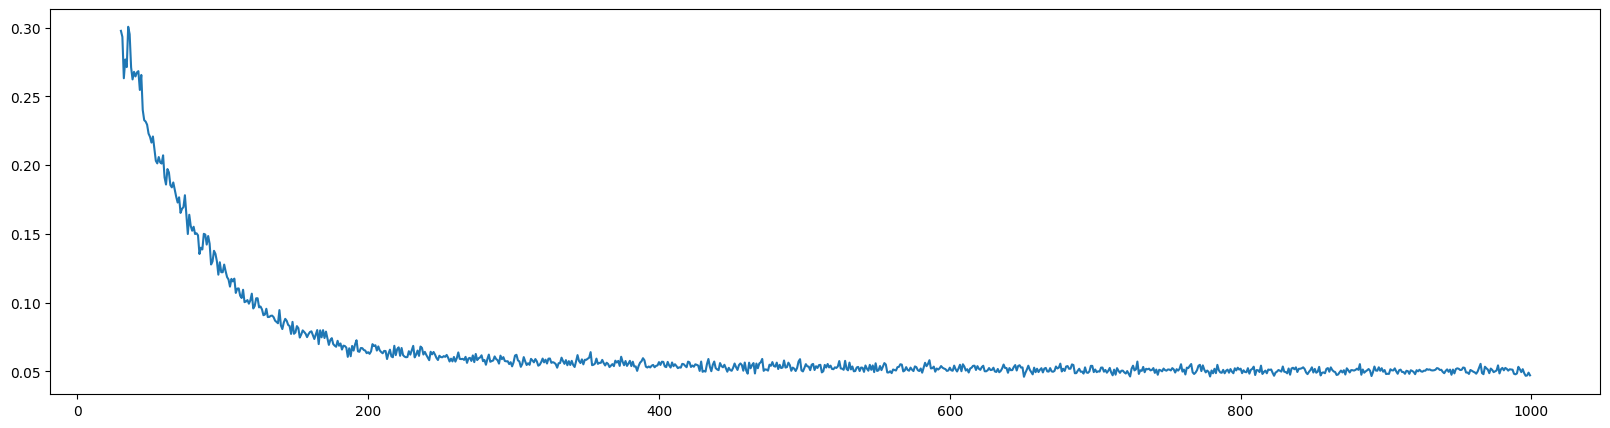

In [88]:
plt.figure(figsize=(20, 5))
plt.plot(loss_result.loc[30: , 'epochs'], loss_result.loc[30: , 'loss'])
plt.show()

### Test

In [89]:
test_result = pd.DataFrame(columns=['pred', 'pred_rescale', 'real'])
num = 0
min = scale_params.loc['min', 'kospi']
max = scale_params.loc['max', 'kospi']
with torch.no_grad():
    for _, data in enumerate(test_dataloader):
        inputs = data[0].to(device).float()
        # outputs = data[1].to(device).float()
        outputs = data[1]

        pred = model(inputs)
        for i in range(len(pred)):
            pred_ = pred.detach().cpu().numpy()[i][0]
            pred_scaled = pred_ * (max - min) + min
            out_scaled = outputs.numpy()[i] * (max - min) + min
            test_result.loc[num] = [pred_, pred_scaled, out_scaled[0]]
            num += 1

In [90]:
test_result

,pred,pred_rescale,real
0,0.713704,2564.957753,2403.760010
1,0.624459,2334.204817,2433.250000
2,0.663589,2435.379437,2486.669922
3,0.679650,2476.906329,2488.179932
4,0.674791,2464.343032,2469.850098
...,...,...,...
135,0.660286,2426.839465,2742.139893
136,0.648076,2395.268092,2724.179932
137,0.692119,2509.146408,2723.459961
138,0.716837,2573.058805,2721.810059


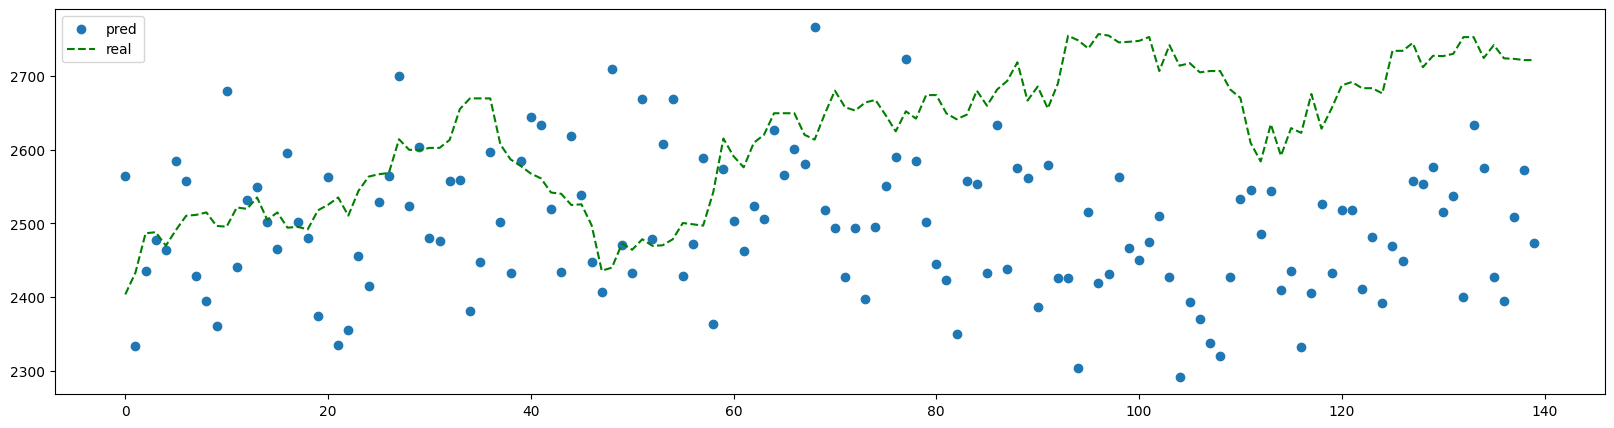

In [91]:
plt.figure(figsize=(20, 5))
# plt.plot(idx_num, test_result['pred'], label='pred')
plt.scatter(range(len(test_result)), test_result['pred_rescale'], label='pred')
plt.plot(range(len(test_result)), test_result['real'], 'g--', label='real')
plt.legend()
plt.show()

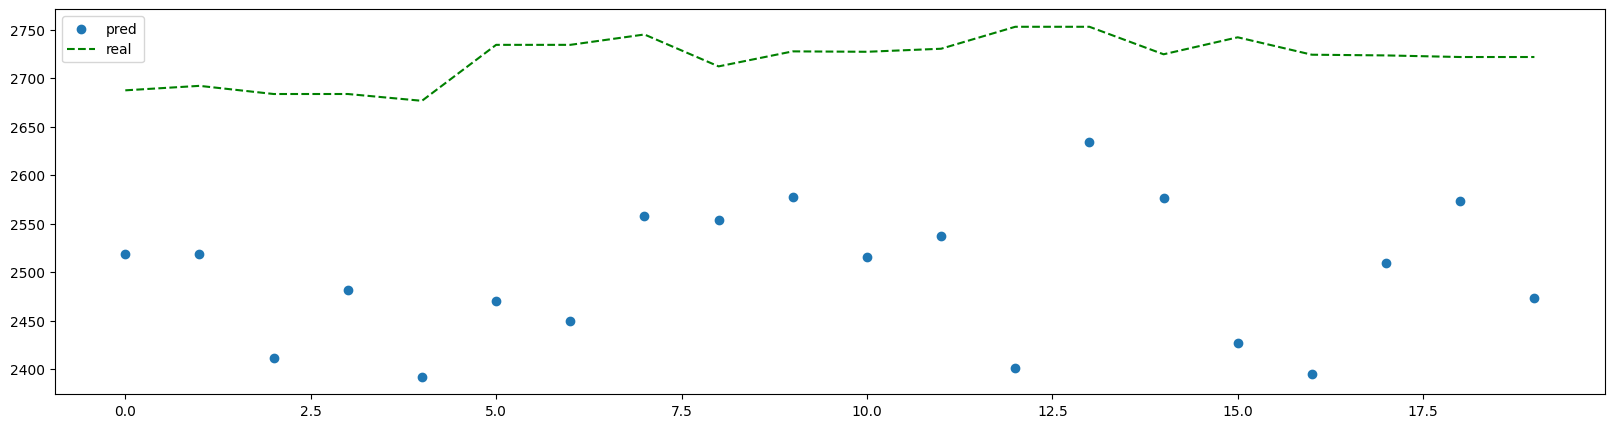

In [92]:
plt.figure(figsize=(20, 5))
# plt.plot(idx_num, test_result['pred'], label='pred')
plt.scatter(range(20), test_result.iloc[-20: , 1], label='pred')
plt.plot(range(20), test_result.iloc[-20: , 2], 'g--', label='real')
# plt.scatter(range(len(test_result)), test_result['pred'], label='pred')
# plt.plot(range(len(test_result)), test_result['real'], 'g--', label='real')
plt.legend()
plt.show()

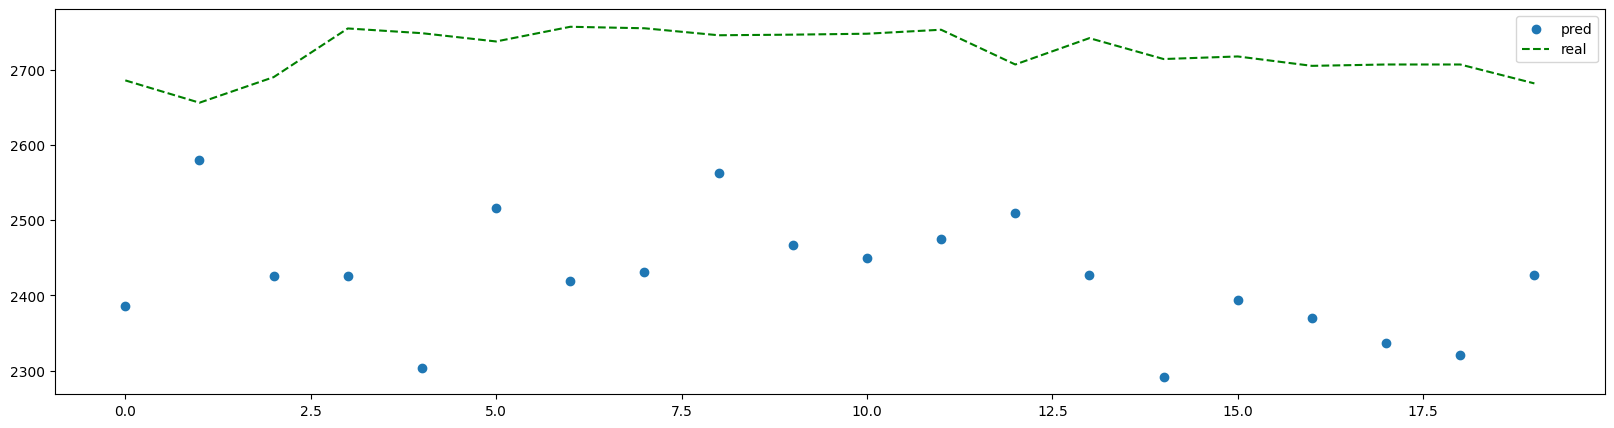

In [93]:
plt.figure(figsize=(20, 5))
# plt.plot(idx_num, test_result['pred'], label='pred')
plt.scatter(range(20), test_result.iloc[-50:-30 , 1], label='pred')
plt.plot(range(20), test_result.iloc[-50:-30 , 2], 'g--', label='real')
# plt.scatter(range(len(test_result)), test_result['pred'], label='pred')
# plt.plot(range(len(test_result)), test_result['real'], 'g--', label='real')
plt.legend()
plt.show()

### moving average check - EMA(Exponential Moving Average)

In [94]:
df_ma = test_result.copy()
df_ma['sma_pred_5d'] = df_ma['pred_rescale'].rolling(5).mean()
df_ma['sma_pred_10d'] = df_ma['pred_rescale'].rolling(10).mean()
df_ma['sma_pred_20d'] = df_ma['pred_rescale'].ewm(20).mean()
df_ma['sma_real_5d'] = df_ma['real'].rolling(5).mean()
df_ma['sma_real_10d'] = df_ma['real'].rolling(10).mean()
df_ma['sma_real_20d'] = df_ma['real'].rolling(20).mean()
df_ma['ewm_pred_5d'] = df_ma['pred_rescale'].ewm(5).mean()
df_ma['ewm_pred_10d'] = df_ma['pred_rescale'].ewm(10).mean()
df_ma['ewm_pred_20d'] = df_ma['pred_rescale'].ewm(20).mean()
df_ma['ewm_real_5d'] = df_ma['real'].ewm(5).mean()
df_ma['ewm_real_10d'] = df_ma['real'].ewm(10).mean()
df_ma['ewm_real_20d'] = df_ma['real'].ewm(20).mean()
df_ma = df_ma.dropna()
df_ma

,pred,pred_rescale,real,sma_pred_5d,sma_pred_10d,sma_pred_20d,sma_real_5d,sma_real_10d,sma_real_20d,ewm_pred_5d,ewm_pred_10d,ewm_pred_20d,ewm_real_5d,ewm_real_10d,ewm_real_20d
19,0.640167,2374.819194,2517.850098,2483.708347,2512.183320,2487.555510,2502.906006,2509.206006,2494.933984,2483.337383,2487.349441,2487.555510,2505.111024,2502.397007,2499.423257
20,0.713242,2563.762129,2525.360107,2503.312633,2500.639524,2493.216290,2504.988037,2512.176025,2501.013989,2497.039343,2495.381414,2493.216290,2508.560859,2504.810729,2501.349898
21,0.625003,2335.610346,2535.270020,2451.252323,2490.145328,2481.813049,2513.186035,2513.527026,2506.114990,2469.638167,2478.822586,2481.813049,2513.094508,2507.967559,2503.804116
22,0.632766,2355.681969,2510.659912,2421.904735,2472.537216,2472.907375,2516.242041,2512.612012,2507.314490,2450.354380,2466.220620,2472.907375,2512.682523,2508.243089,2504.288180
23,0.671246,2455.177507,2544.179932,2417.010229,2463.107338,2471.683661,2526.664014,2513.501001,2510.114490,2451.168475,2465.103260,2471.683661,2517.998967,2511.879237,2507.041505
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,0.660286,2426.839465,2742.139893,2514.880810,2522.826083,2483.846377,2740.620020,2734.948999,2704.550000,2508.048914,2494.460214,2483.846377,2727.711889,2713.083505,2697.110942
136,0.648076,2395.268092,2724.179932,2486.544247,2517.433200,2479.623082,2739.387988,2733.930981,2709.607996,2489.252110,2485.442729,2479.623082,2727.123229,2714.092274,2698.401555
137,0.692119,2509.146408,2723.459961,2508.236791,2512.519090,2481.030631,2733.479980,2731.771973,2711.993494,2492.567827,2487.597613,2481.030631,2726.512685,2714.943883,2699.596235
138,0.716837,2573.058805,2721.810059,2496.044725,2514.418542,2485.417901,2727.241992,2732.738989,2716.652991,2505.982990,2495.366826,2485.417901,2725.728914,2715.568082,2700.655237


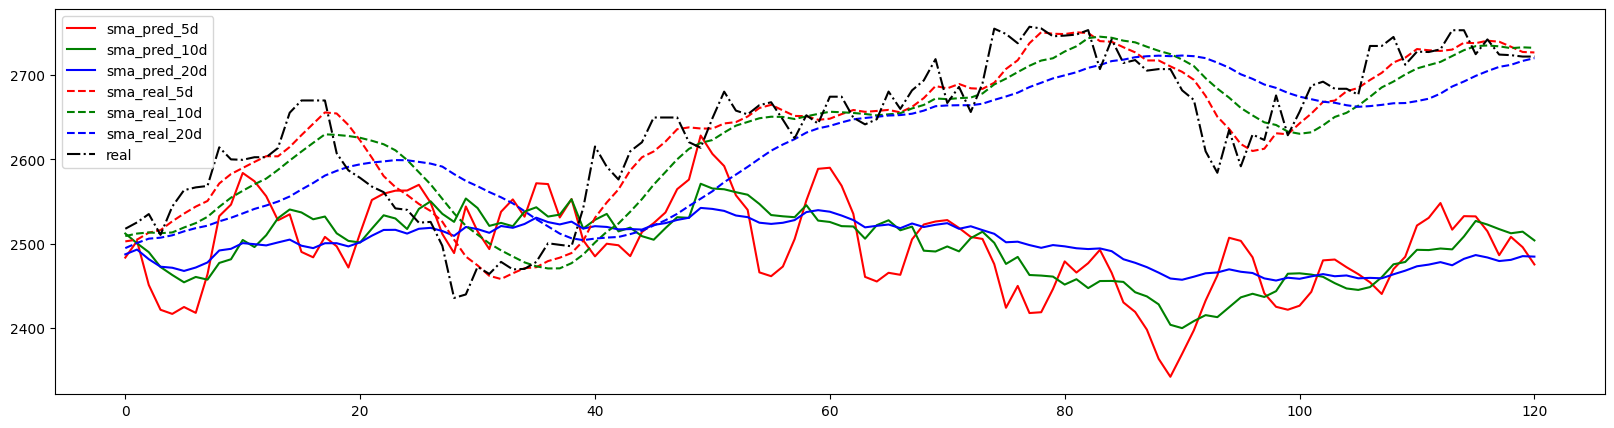

In [95]:
plt.figure(figsize=(20, 5))
plt.plot(range(len(df_ma)), df_ma['sma_pred_5d'], 'r-', label='sma_pred_5d')
plt.plot(range(len(df_ma)), df_ma['sma_pred_10d'], 'g-', label='sma_pred_10d')
plt.plot(range(len(df_ma)), df_ma['sma_pred_20d'], 'b-', label='sma_pred_20d')
plt.plot(range(len(df_ma)), df_ma['sma_real_5d'], 'r--', label='sma_real_5d')
plt.plot(range(len(df_ma)), df_ma['sma_real_10d'], 'g--', label='sma_real_10d')
plt.plot(range(len(df_ma)), df_ma['sma_real_20d'], 'b--', label='sma_real_20d')
plt.plot(range(len(df_ma)), df_ma['real'], 'k-.', label='real')
plt.legend()
plt.show()

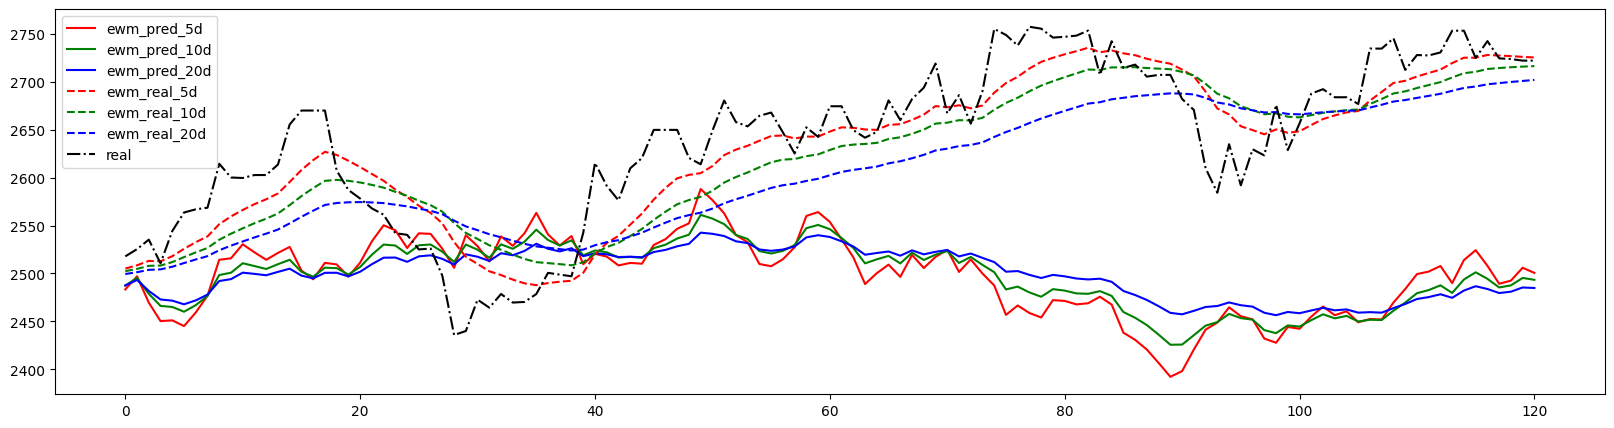

In [96]:
plt.figure(figsize=(20, 5))
plt.plot(range(len(df_ma)), df_ma['ewm_pred_5d'], 'r-', label='ewm_pred_5d')
plt.plot(range(len(df_ma)), df_ma['ewm_pred_10d'], 'g-', label='ewm_pred_10d')
plt.plot(range(len(df_ma)), df_ma['ewm_pred_20d'], 'b-', label='ewm_pred_20d')
plt.plot(range(len(df_ma)), df_ma['ewm_real_5d'], 'r--', label='ewm_real_5d')
plt.plot(range(len(df_ma)), df_ma['ewm_real_10d'], 'g--', label='ewm_real_10d')
plt.plot(range(len(df_ma)), df_ma['ewm_real_20d'], 'b--', label='ewm_real_20d')
plt.plot(range(len(df_ma)), df_ma['real'], 'k-.', label='real')
plt.legend()
plt.show()

## evaluation metrics
MAPE, MSE

In [97]:
mse = mean_squared_error(test_result['real'], test_result['pred_rescale'])
mape = mean_absolute_percentage_error(test_result['real'], test_result['pred_rescale'])
print(f'MSE: {mse:.4f}, MAPE: {mape:.4f}')

MSE: 33997.0829, MAPE: 0.0573
